 # Setup
 First, import relevant modules. The alloys module is a custom module which contains useful methods for analysing this dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import alloys as al


# Import the data
Now we import the data using the **importPT** command from the alloys module

In [2]:
X = al.importNovamag('./data')

Found directory: ./data
Found directory: ./data/Periodic-table
Import failed
Import failed
Import failed
Found directory: ./data/TUDA
Found directory: ./data/TUDA/FeNiN
Found directory: ./data/TUDA/Tetragonally_distortion_cubic
Found directory: ./data/ICCRAM_UBU
Found directory: ./data/ICCRAM_UBU/AGA
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Nb
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Nb/5-1
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Nb/2-1
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Nb/6-1
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Nb/3-1
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Nb/4-1
Found directory: ./data/ICCRAM_UBU/AGA/Co-Ta
Found directory: ./data/ICCRAM_UBU/AGA/Co-Ta/5-1
Found directory: ./data/ICCRAM_UBU/AGA/Co-Ta/6-1
Found directory: ./data/ICCRAM_UBU/AGA/Co-Ta/7-1
Found directory: ./data/ICCRAM_UBU/AGA/Co-Ta/5-2
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Si
Found directory: ./data/ICCRAM_UBU/AGA/Fe-Si/1-1
Import failed
Import failed
Import failed
Found directory: ./data/ICCRAM_

Also, import generic data from the periodic table and Miedema binary enthalpy of mixing values. 

In [3]:
PT = al.importPT('./data/Periodic-table/periodic_table.xlsx')
MM = al.importMM('./data/Miedema-model/Miedema-model-reduced.xlsx')

# Explore the data
Now start to investigate the data.

In [4]:
print('The total number of imported features is {0}'.format(len(X.columns)))

# Fix the 'none' values
X = X.fillna(value=np.nan).copy()

# Find columns with missing values
na_cols = [col for col in X.columns if X[col].isna().any()]
print('The number of features with at least one NaN value is {0}'.format(
                                                              len(na_cols)))

# drop colums with more than 10 NaN values
dropped_cols = []
for col in na_cols:
    count = X[col].isna().sum()
    print('Column \'{0}\' has {1} nan values'.format(col, count))
    if count > 10:
        print('Dropping column \'{0}\''.format(col))
        dropped_cols.append(col)
        X = X.drop(col, axis=1).copy()
print('Number of dropped features is: {0}'.format(len(dropped_cols)))

The total number of imported features is 32
The number of features with at least one NaN value is 30
Column 'production info' has 6 nan values
Column 'unit cell volume' has 22 nan values
Dropping column 'unit cell volume'
Column 'lattice parameters' has 15 nan values
Dropping column 'lattice parameters'
Column 'lattice angles' has 11 nan values
Dropping column 'lattice angles'
Column 'atomic positions' has 22 nan values
Dropping column 'atomic positions'
Column 'crystal info' has 11 nan values
Dropping column 'crystal info'
Column 'unit cell spin polarization' has 636 nan values
Dropping column 'unit cell spin polarization'
Column 'atomic spin specie' has 636 nan values
Dropping column 'atomic spin specie'
Column 'saturation magnetization' has 7 nan values
Column 'magnetization temperature' has 18 nan values
Dropping column 'magnetization temperature'
Column 'magnetization info' has 29 nan values
Dropping column 'magnetization info'
Column 'magnetocrystalline anisotropy energy' has 166

**Saturation magnetisation has only 7 missing values**, which would make it a good property to attempt regression modeling with. 

The other features could be of interest for the future, but for now we are interested in making predictions based features that can be derived from the chemical formula alone, since this information is readily available for candidate alloy systems which may not exist just yet. 

Now we have a target, lets drop those 7 rows which had missing values:

In [5]:
# Drop all columns except the target and chemical formulas
X = X[['chemical formula', 'saturation magnetization']]

# Remove rows with missing target, separate target from predictors
# X.dropna(axis=0, subset=['saturation magnetization'], inplace=True)

We will now investigate the chemical formula and the distribution of elements here. 

In [6]:
# How many compounds do we have?
foo = len(X['chemical formula'])
print('Total number of compounds = {0}'.format(foo))

# Are all compounds unique?
print('The top 10 most recurring compounds')
print(X['chemical formula'].value_counts()[:9])

# Number of unique compounds
bar = X['chemical formula'].nunique()
print('Number of unique compounds = {0}'.format(bar))
print('Only {:.0f}% of the data set is made up of unique compounds'.format(100*bar/foo))

Total number of compounds = 1662
The top 10 most recurring compounds
Co2Fe12Ta2    25
Co1Fe8Ta1     24
Fe8N1         23
Fe12Ta4       21
Co1Fe6Ta1     20
Fe16Ta4       20
Co1Fe10Ta1    18
Fe10N2        18
Fe8N2         18
Name: chemical formula, dtype: int64
Number of unique compounds = 791
Only 48% of the data set is made up of unique compounds


This is an issue with the data set, which was already on the small side. We will need to find a robust method of treating these duplicate values (we will come back to this when training the model)

## Distribution of individual elements in the database.

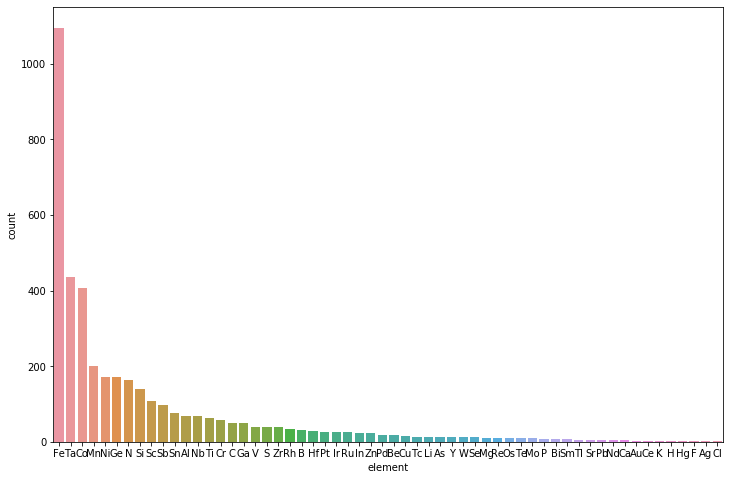

In [7]:
# Plot up the distribution of elements
n_el = al.get_element_occurance(X, PT)
plt.figure(figsize=(12,8))
n_el = n_el[n_el['count'] > 0]
n_el = n_el.sort_values(['count'], ascending=False)
ch = sns.barplot(x=n_el['element'], y=n_el['count'])
# For reverse order, use n['count'][::-1]
# ch.set_xticklabels(ch.get_xticklabels(), rotation=90, horizontalalignment='center')

Fe is bar far the most common element, followed by Ta and Co. Ni is the 5th most common element. There is clearly some bias towards Ta based alloys in this dataset. Ta is contained in six of the ten most commonly occuring alloys in this dataset. This combined with preponderance of Fe, Co and Ta suggests that the researchers had a particular interest in FeCoTa based alloys. 

## Distribution of occurance of select elements and the resulting saturation magnetisation of the alloy

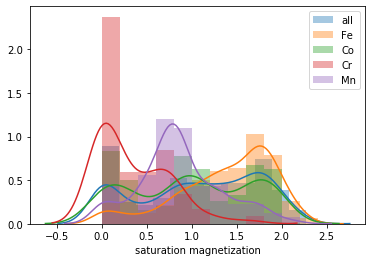

In [8]:
# Make some sub-datasets grouped by elements
X_Fe = X[X['chemical formula'].str.contains(pat='Fe')]
X_Co = X[X['chemical formula'].str.contains(pat='Co')]
X_Cr = X[X['chemical formula'].str.contains(pat='Cr')]
X_Mn = X[X['chemical formula'].str.contains(pat='Mn')]

plt.figure()
bins = np.arange(0, 2.6, 0.2)
sns.distplot(a = X['saturation magnetization'], kde = True, label = 'all') 
sns.distplot(a=X_Fe['saturation magnetization'], kde=True, bins=bins, label='Fe')
sns.distplot(a=X_Co['saturation magnetization'], kde=True, bins=bins, label='Co')
sns.distplot(a=X_Cr['saturation magnetization'], kde=True, bins=bins, label='Cr') 
sns.distplot(a=X_Mn['saturation magnetization'], kde=True, bins=bins, label='Mn')
plt.legend()

Here we can see that Fe based alloys tend to have the highest saturation magnetization, whereas Cr based alloys have the lowest. This is not too surprising given that Cr is an antiferromagnet. 

In [9]:
# # How many binary, ternary, quaternary compounds do we have?
X['compoundradix'] = al.get_CompoundRadix(PT, X)
total_compound_radix = X['compoundradix'].value_counts()
print('We have {0} binary compounds'.format(total_compound_radix[2]))
print('We have {0} ternary compounds'.format(total_compound_radix[3]))
print('We have {0} quarternary compounds'.format(total_compound_radix[4]))

We have 998 binary compounds
We have 647 ternary compounds
We have 14 quarternary compounds


### An aside: Mn containing alloys
I have a particular interest in Mn based alloys, for which Mn can take on either a ferromagnetic or antiferromagnetic polarisation. 
We will next investigate what elements the researchers typically chose to alloy with Mn.

In [10]:
print('The Novomag data set contain {0} Mn containing compounds'.format(len(X_Mn)))
X_Mn = X_Mn.sort_values(['saturation magnetization'], ascending=False)

print('The Mn containing compounds with the highest saturation magnetization are \n {0}'.format(
    np.array([X_Mn['chemical formula'].iloc[0:4], X_Mn['saturation magnetization'].iloc[0:4]])))

print('The Mn containing compounds with the lowest saturation magnetization are \n {0}'.format(
    np.array([X_Mn['chemical formula'].iloc[-4:], X_Mn['saturation magnetization'].iloc[-4:]])))

foo = X_Mn['saturation magnetization'].mean()
print('The mean saturation magnetization for a Mn containing compound is {0:.2f} T'.format(foo))

foo = X['saturation magnetization'].round(decimals=1).median()
print('The median saturation magnetization for a Mn containing compound is {0:.1f} T'.format(foo))

The Novomag data set contain 200 Mn containing compounds
The Mn containing compounds with the highest saturation magnetization are 
 [['Mn3Pt1' 'Mn1Ni1' 'Mn4N4' 'Mn3Pt1N1']
 [2.14406 2.04965 2.00078 1.8321]]
The Mn containing compounds with the lowest saturation magnetization are 
 [['Fe6Mn6Sn3Sb1' 'Fe8Mn4Sn3Sb1' 'Fe15Mn15Sn9Sb1' 'Fe9Mn3Sn3Sb1']
 [nan nan nan nan]]
The mean saturation magnetization for a Mn containing compound is 0.87 T
The median saturation magnetization for a Mn containing compound is 1.2 T


# Building the features

Before we can build features we need to encode the chemical formula information for each compound into a usable format. 

To do this, we build a stoichiometry array, which comprises of one row for each compounds and a columns for each element in the periodic table. The number of atoms of a given element in the chemical formula is stored in the respective column for that element. e.g the row for Co2Fe4Mn1 would have a 2 in the Co column, a 4 in the Fe column, a 1 in the Mn column and 0 in every other column. 

The stoichiometry array is generated using the get_stoich_array command in the alloys module:

In [11]:
stoich_array = al.get_stoich_array(X, PT)

/Users/richard/Projects/Machine-Learning/ML-alloy-design/alloys.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stoich_array[el][regex_list.index] = regex_list.digit


With the chemical formula data encoded, we can now build features based on this data using the relevent commands from the alloys module:

In [12]:
X['stoicentw'] = al.get_StoicEntw(stoich_array)  # Stoicheometry weighted mixing entropy
X['Zw'] = al.get_Zw(PT, stoich_array)           # Stoicheometry weighted atomic mass
# X['compoundradix'] = al.get_CompoundRadix(PT, X)  # Compound radix, i.e. binary, ternary, quaternary...
X['periodw'] = al.get_Periodw(PT, stoich_array)   # Stoicheometry weighted periodic table period
X['groupw'] = al.get_Groupw(PT, stoich_array)   # Stoicheometry weighted periodic table group
X['meltingTw'] = al.get_MeltingTw(PT, stoich_array) # Stoicheometry weighted melting point
X['miedemaH'] = al.get_Miedemaw(MM, stoich_array) # Stoicheometry weighted Miedema enthalpy of mixing
X['valencew'] = al.get_Valencew(PT, stoich_array) # Stoicheometry weighted valency
X['electronegw'] = al.get_Electronegw(PT, stoich_array) # Stoicheometry weighted electronegativity
print('Finished')

Finished


## Data cleaning

In [13]:
my_cols = ['stoicentw',
           'Zw',
           'periodw',
           'groupw',
           'meltingTw',
           'miedemaH',
           'valencew',
           'electronegw']

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['saturation magnetization'] + my_cols, inplace=True)
# Drop alloys which are below magnetic cutoff (determined through prior model optimisation)
X.drop(X[X['saturation magnetization'] < 0.18].index, axis=0, inplace=True)


In [14]:
# Round the saturation magnetization to 1.d.p
X['saturation magnetization'] = pd.to_numeric(
    X['saturation magnetization']).round(decimals=2)

# Group duplicates by chemical formula and replace values with median
X = X.groupby(by='chemical formula').median()
X.index = range(len(X))

# define the target as the series 'y' and drop this from the dataframe 'X'.
y = X['saturation magnetization']
X.drop(['saturation magnetization'], axis=1, inplace=True)

## Exploratory data analysis with the generated features

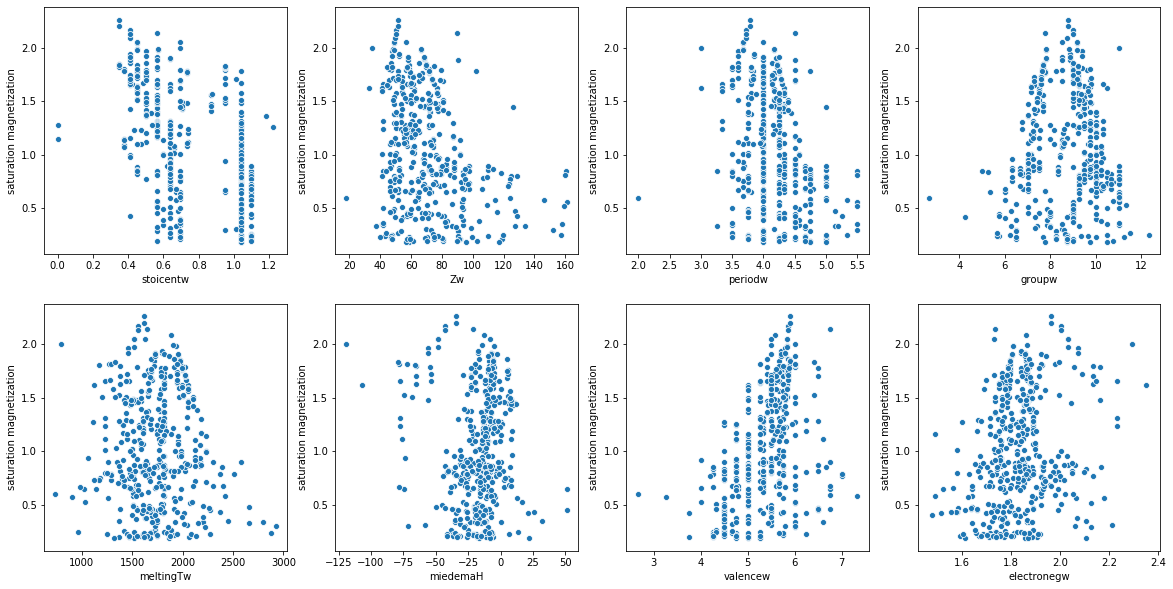

In [15]:

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for col, subplot in zip(my_cols, ax.flatten()):
    ch = sns.scatterplot(x=X[col], y=y, ax=subplot)

# Fit a Random Forest regression model

In [16]:
train_size = 0.8
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=train_size,
                                                      test_size=1-train_size,
                                                      random_state=0)
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()

model = RandomForestRegressor(
    n_estimators=270, random_state=0, max_depth=16)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=270, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Preprocessing of validation data, getting predictions:

In [17]:
preds = model.predict(X_valid)
scores = mean_absolute_error(y_valid, preds)
print('RF - cutoff {0}: MAE: {1}'.format(0.18, scores))

RF - cutoff 0.18: MAE: 0.18350852574214785


In [18]:
# Do k-fold cross validation to assess model
folds = 5
cv = ShuffleSplit(n_splits=folds, test_size=0.2, random_state=0)
scores = cross_val_score(
    model, X[my_cols], y, scoring='neg_mean_absolute_error', cv=cv)
print('------------------------------------')
print('Mean {0}-fold validation score: {1:.3f}, train_size = {2}'.format(folds,
                                                        abs(scores).mean(),train_size))
print('------------------------------------')

------------------------------------
Mean 5-fold validation score: 0.177, train_size = 0.8
------------------------------------


The mean 5-fold cross validation score is similar to that obtained on the training data set, suggesting that we aren't overly biased to the training set. 

On average the predicted saturation magnetization has an error of **0.18 T**. Lets explore that in more detail, first plotting the correlation between predicted and actual saturation magnetization:

Text(0, 0.5, 'Predicted Saturation magnetisation [T]')

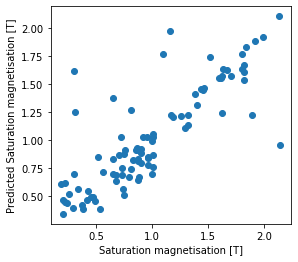

In [19]:
plt.figure()
plt.gca().set_aspect('equal')
plt.plot(y_valid, preds, 'o')
plt.xlabel('Saturation magnetisation [T]')
plt.ylabel('Predicted Saturation magnetisation [T]')

Investigate the distrution of absolute errors on the predicted saturation magnetization:

Critical exponent extracted from MAE distribution is 0.15 T
80% of the data has an error less than 0.25 T


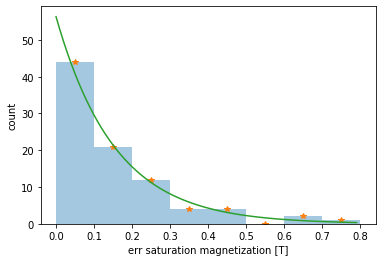

In [20]:
err = y_valid - preds
plt.figure()
ch = sns.distplot(a=abs(err), bins=[0, .1, .2, .3, .4, .5, .6, .7, .8], kde=False)
ch.set(xlabel='err saturation magnetization [T]', ylabel='count')
a = np.histogram(abs(err), bins=[0,.1,.2,.3,.4,.5,.6,.7,.8])
plt.plot(a[1][1:]-0.05, a[0],'*')

m = np.polyfit(a[1][1:6]-0.05, np.log(a[0][0:5]), deg=1)
plt.plot(np.arange(0,0.8,0.01), np.exp(np.arange(0,0.8,0.01)*m[0] + m[1]), '-')
print('Critical exponent extracted from MAE distribution is {0:.2f} T'.format(-1/m[0]))

print('80% of the data has an error less than {0:.2f} T'.format(np.log(1-0.8)/m[0]))

## Test predictions of model with literature
The binary Ni-Mn alloy system shows a peak around 10% Mn, so not a simple monotomic relationship and would therefore make an interesting test case.

/Users/richard/Projects/Machine-Learning/ML-alloy-design/alloys.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stoich_array[el][regex_list.index] = regex_list.digit


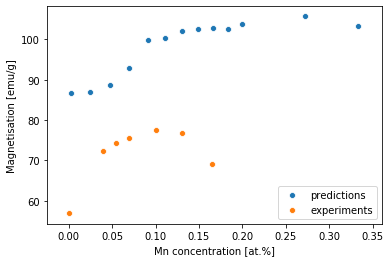

In [26]:
# First set out the chemical formulas we want to make predictions for:
X_NiMn = pd.DataFrame(['Ni400Mn1', 'Ni40Mn1', 'Ni40Mn2', 'Ni40Mn3',
                           'Ni40Mn4', 'Ni40Mn5', 'Ni40Mn6', 'Ni40Mn7',
                           'Ni40Mn8', 'Ni40Mn9', 'Ni40Mn10', 'Ni40Mn15', 'Ni40Mn20'],
                          columns=['chemical formula'])

# Now build the stoichiometry array with this chemical formulas:
stoich_array_NiMn = al.get_stoich_array(X_NiMn, PT)

# With the stoic_array, we can generate the features:
X_NiMn['stoicentw'] = al.get_StoicEntw(stoich_array_NiMn)
X_NiMn['Zw'] = al.get_Zw(PT, stoich_array_NiMn)
X_NiMn['compoundradix'] = al.get_CompoundRadix(PT, X_NiMn)
X_NiMn['periodw'] = al.get_Periodw(PT, stoich_array_NiMn)
X_NiMn['groupw'] = al.get_Groupw(PT, stoich_array_NiMn)
X_NiMn['meltingTw'] = al.get_MeltingTw(PT, stoich_array_NiMn)
X_NiMn['miedemaH'] = al.get_Miedemaw(MM, stoich_array_NiMn)
X_NiMn['valencew'] = al.get_Valencew(PT, stoich_array_NiMn)
X_NiMn['electronegw'] = al.get_Electronegw(PT, stoich_array_NiMn)

# Make predictions using the trained model:
preds_NiMn = model.predict(X_NiMn[my_cols])

# Calculate atomic fractions for NiMn compositions (for converting Tesla to emu/g)
at_fraction = al.get_AtomicFrac(stoich_array_NiMn)
# Convert Tesla to emu/g
rho_Ni = 8.9  # [g/cm3]
rho_Mn = 7.4  # [g/cm3]
rho_NiMn = (rho_Ni*at_fraction['Ni'] + rho_Mn*at_fraction['Mn'])
preds_NiMn = preds_NiMn/((4*np.pi*1e-4)*rho_NiMn)

# Convert bohr magnetron to emu/g
Exp_NiMn = pd.Series(data=[0.6, 0.76, 0.78, 0.79, 0.81, 0.8, 0.72],
                     index=[0, 0.04, 0.055, 0.07, 0.1, 0.13, 0.165])
M_Ni = 58.693
M_Mn = 54.938
formula_mass = ((M_Ni*(1-Exp_NiMn.index) + M_Mn*Exp_NiMn.index))/6.022e23
Exp_NiMn = (Exp_NiMn*9.27e-21)/formula_mass

plt.figure()
sns.scatterplot(x=at_fraction['Mn'], y=preds_NiMn)
sns.scatterplot(x=Exp_NiMn.index, y=Exp_NiMn.array)
plt.xlabel('Mn concentration [at.%]')
plt.ylabel('Magnetisation [emu/g]')
plt.legend(['predictions','experiments'])